In [3]:
import numpy as np
import hickle as hkl
import seaborn as sns
import seaborn_image as isns

In [2]:
middle = '../src/test_example.npy'
print(np.load(middle).shape)

FileNotFoundError: [Errno 2] No such file or directory: '../src/test_example.npy'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(618, 612, 13) (618, 612, 13)
(618, 612, 13) (618, 612, 13)
(618, 612, 13) (618, 612, 13)


<Figure size 2000x1000 with 0 Axes>

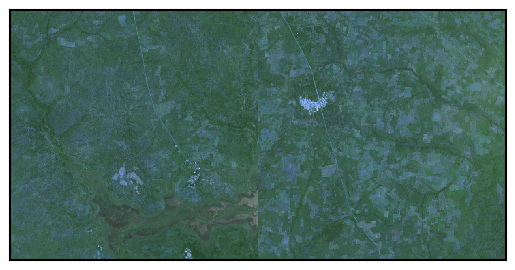

In [10]:
import matplotlib.pyplot as plt

left = "../src/1674X1100Y_ard.hkl"
right = "../src/1661X1067Y_ard.hkl"
#middle = '../src/test_example.npy'
def adjust_ard(left, right, middle):
   
    l = hkl.load(left)#[..., :13]
    r = hkl.load(right)#[..., :13]
    m = np.load(middle)#[..., :13]
    print(l.shape, r.shape)
    inp_mid_shape = m.shape[1]
    out_mid_shape = l.shape[1]
    middle_adjust = (inp_mid_shape - out_mid_shape) // 2
    m = m[:, middle_adjust:-middle_adjust, :]
    half = m.shape[1] // 2
    lsize = l.shape[1] - (half)
    rsize = lsize + half + half
    print(l.shape, r.shape, m.shape)
    img = np.concatenate([l, r], axis = 1)


    sums = np.zeros((img.shape[0], img.shape[1]), dtype = np.float32)
    print(l.shape[0] // 2)
    sums[:, :l.shape[0] // 2] = 1
    sums[:, l.shape[0] // 2:(l.shape[0] // 2)+half] += (1 - (np.arange(0, half, 1) / half))
    sums[:, (l.shape[0] // 2)+half:(l.shape[0] // 2)+half+half] += ((np.arange(0, half, 1) / half))
    sums[:, -(r.shape[0] // 2):] = 1.
    sums = sums[..., np.newaxis]
    sumsright = 1 - sums
    img[..., :10] = img[..., :10] * sums
    img[:, lsize:rsize, :10] += (m[..., :10]* (1 - sums[:, lsize:rsize]))
    leftfile = img[:, :l.shape[1]]
    rightfile = img[:, -r.shape[1]:]
    #hkl.dump(leftfile, left, mode='w', compression='gzip')
   # hkl.dump(rightfile, right,  mode='w', compression='gzip')
    return img, sums


img, _ = adjust_ard(left, right, middle)
plt.figure(figsize =(20, 10))
isns.imgplot(img[..., :3] *  5, robust = True)
plt.show()

309
(618, 612, 13) (618, 612, 13)


<Figure size 1000x2000 with 0 Axes>

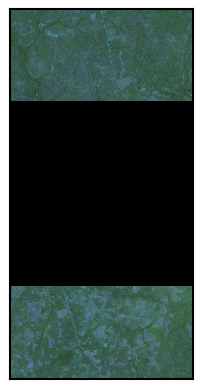

In [14]:
import matplotlib.pyplot as plt

#left = "../src/1663X1069Y_ard.hkl"
#right = "../src/1663X1068Y_ard.hkl"
middle = '../src/1674X1100Y_ard.hkl'
def adjust_ard(left, right, middle):
   
    l = hkl.load(left)#[..., :13]
    r = hkl.load(right)#[..., :13]
    m = hkl.load(middle)#[..., :13]
    img = np.concatenate([l, r], axis = 0)

    inp_mid_shape = m.shape[0]
    out_mid_shape = l.shape[0]
    middle_adjust = (inp_mid_shape - out_mid_shape) // 2
    m = m[middle_adjust:-middle_adjust, :]    

    half = m.shape[0] // 2
    lsize = l.shape[0] - (half)
    rsize = lsize + half + half
    
    sums = np.zeros((img.shape[0], img.shape[1]), dtype = np.float32)
    print(l.shape[0] // 2)
    sums[:l.shape[0] // 2] = 1
    sums[l.shape[0] // 2:(l.shape[0] // 2)+half, :] += (1 - (np.arange(0, half, 1) / half))[:, np.newaxis]
    sums[(l.shape[0] // 2)+half:(l.shape[0] // 2)+half+half] += ((np.arange(0, half, 1) / half))[:, np.newaxis]
    sums[-(r.shape[0] // 2):] = 1.
    #sums = sums[..., np.newaxis]

    sumsright = 1 - sums
    img[..., :10] = img[..., :10] * sums[..., np.newaxis]
    img[lsize:rsize, :, :10] += (m[..., :10]* (1 - sums[lsize:rsize][..., np.newaxis]))
    leftfile = img[:l.shape[0]]
    rightfile = img[-r.shape[0]:]
    print(leftfile.shape, rightfile.shape)
    return img, l, r


img, l, r = adjust_ard(left, right, middle)
plt.figure(figsize =(10, 20))
isns.imgplot(img[..., :3] *  5, robust = True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


309


<Figure size 1000x2000 with 0 Axes>

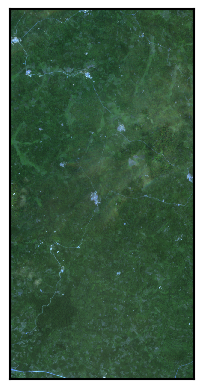

In [271]:
import matplotlib.pyplot as plt

left = "../src/1663X1069Y_ard.hkl"
right = "../src/1663X1068Y_ard.hkl"
middle = '../src/test_example.npy'
def adjust_ard(left, right, middle):
   
    l = hkl.load(left)#[..., :13]
    r = hkl.load(right)#[..., :13]
    m = np.load(middle)#[..., :13]
    img = np.concatenate([l, r], axis = 0)

    inp_mid_shape = m.shape[0]
    out_mid_shape = l.shape[0]
    middle_adjust = (inp_mid_shape - out_mid_shape) // 2
    m = m[middle_adjust:-middle_adjust, :]    

    half = m.shape[0] // 2
    lsize = l.shape[0] - (half)
    rsize = lsize + half + half
    
    sums = np.zeros((img.shape[0], img.shape[1]), dtype = np.float32)
    print(l.shape[0] // 2)
    sums[:l.shape[0] // 2] = 1
    sums[l.shape[0] // 2:(l.shape[0] // 2)+half, :] += (1 - (np.arange(0, half, 1) / half))[:, np.newaxis]
    sums[(l.shape[0] // 2)+half:(l.shape[0] // 2)+half+half] += ((np.arange(0, half, 1) / half))[:, np.newaxis]
    sums[-(r.shape[0] // 2):] = 1.
    #sums = sums[..., np.newaxis]

    sumsright = 1 - sums
    img[..., :10] = img[..., :10] * sums[..., np.newaxis]
    img[lsize:rsize, :, :10] += (m[..., :10]* (1 - sums[lsize:rsize][..., np.newaxis]))
    leftfile = img[:l.shape[1]]
    rightfile = img[-r.shape[1]:]
    return img, leftfile, rightfile


img, l, r = adjust_ard(left, right, middle)
plt.figure(figsize =(10, 20))
isns.imgplot(img[..., :3] *  5, robust = True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1000x2000 with 0 Axes>

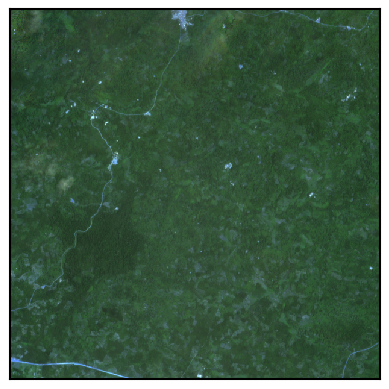

In [274]:
plt.figure(figsize =(10, 20))
isns.imgplot(r[..., :3] *  5, robust = True)
plt.show()